In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.io import imshow
import math
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Input
)
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from skimage.io import imshow
from os.path import join
import glob
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

2022-11-16 15:22:02.660978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 15:22:02.902545: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 15:22:03.720439: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moez/cuda_installation/cuda/lib64:/usr/local/cuda-11.2/lib64
2022-11-16 15:22:03.720515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
DATA_PATH = "./facial-keypoints-detection"

# Data
## Loading

In [3]:
def has_nan(keypoints):
    for i in range(len(keypoints)):
        if math.isnan(keypoints[i]):
            return True
    return False

def visualize_points(img, points):
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    imshow(img)
    for i in range(0,len(points),2):
        x_renorm = (points[i]+0.5)*96       # Denormalize x-coordinate
        y_renorm = (points[i+1]+0.5)*96     # Denormalize y-coordinate
        circ = Circle((x_renorm, y_renorm),1, color='r')    # Plot the keypoints at the x and y coordinates
        ax.add_patch(circ)
    plt.show()

In [4]:
training = pd.read_csv(DATA_PATH + '/training.csv')
test = pd.read_csv(DATA_PATH + '/test.csv')

## Processing

In [5]:
imgs_train = []
points_train = []
for i in tqdm(range(len(training))):
    points = training.iloc[i,:-1]
    if has_nan(points) is False:
        test_image = training.iloc[i,-1]        # Get the image data
        test_image = np.array(test_image.split(' ')).astype(int)    
        test_image = np.reshape(test_image, (96,96))        # Reshape into an array of size 96x96
        test_image = test_image/255         # Normalize image
        imgs_train.append(test_image)
        
        keypoints = training.iloc[i,:-1].astype(int).values
        keypoints = keypoints/96 - 0.5  # Normalize keypoint coordinates
        points_train.append(keypoints)

imgs_train = np.array(imgs_train)    
points_train = np.array(points_train)

# Get test data
imgs_test = []
for i in tqdm(range(len(test))):
    test_image = test.iloc[i,-1]        # Get the image data
    test_image = np.array(test_image.split(' ')).astype(int)
    test_image = np.reshape(test_image, (96,96))        # Reshape into an array of size 96x96
    test_image = test_image/255     # Normalize image   
    imgs_test.append(test_image)
    
imgs_test = np.array(imgs_test)

100%|██████████| 1783/1783 [00:08<00:00, 200.13it/s]


## Augmentation

In [6]:
def augment(img, points):
    f_img = img[:, ::-1]        # Mirror the image
    for i in range(0,len(points),2):        # Mirror the key point coordinates
        x_renorm = (points[i]+0.5)*96       # Denormalize x-coordinate
        dx = x_renorm - 48          # Get distance to midpoint
        x_renorm_flipped = x_renorm - 2*dx      
        points[i] = x_renorm_flipped/96 - 0.5       # Normalize x-coordinate
    return f_img, points

aug_imgs_train = []
aug_points_train = []
for i, img in enumerate(imgs_train):
    f_img, f_points = augment(img, points_train[i])
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)

# Combine the original data and augmented data
imgs_total = np.concatenate((imgs_train, aug_imgs_train), axis=0)       
points_total = np.concatenate((points_train, aug_points_train), axis=0)

In [7]:
def get_train_data():
    imgs_total_reshaped = np.reshape(imgs_total, (imgs_total.shape[0],imgs_total.shape[1],imgs_total.shape[2], 1))
    return imgs_total_reshaped,points_total

def get_test_data():
    return imgs_test

# Training

In [8]:
imgs_train, points_train = get_train_data()
imgs_test = get_test_data()

## Neural Network

In [9]:
def get_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(96,96,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(30))
    return model

model = get_model()
def compile_model(model):
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])

def train_model(model):
    checkpoint = ModelCheckpoint(filepath='weights/checkpoint-{epoch:02d}.hdf5')
    history = model.fit(imgs_train, points_train, epochs=300, batch_size=100, callbacks=[checkpoint])
    return history

def load_trained_model(model):
    model.load_weights('weights/checkpoint-300.hdf5')


2022-11-16 15:22:30.030045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:22:30.038145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:22:30.038402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:22:30.038918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
model = get_model()
compile_model(model)
history = train_model(model)

Epoch 1/300


2022-11-16 15:22:32.893741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


5/5 [==============================] - 5s 257ms/step - loss: 0.1564 - accuracy: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 1s 178ms/step - loss: 0.1042 - accuracy: 0.0023
Epoch 3/300
5/5 [==============================] - 1s 179ms/step - loss: 0.0770 - accuracy: 0.0407
Epoch 4/300
5/5 [==============================] - 1s 167ms/step - loss: 0.0597 - accuracy: 0.2301
Epoch 5/300
5/5 [==============================] - 1s 178ms/step - loss: 0.0490 - accuracy: 0.3544
Epoch 6/300
5/5 [==============================] - 1s 176ms/step - loss: 0.0432 - accuracy: 0.4152
Epoch 7/300
5/5 [==============================] - 1s 173ms/step - loss: 0.0394 - accuracy: 0.4386
Epoch 8/300
5/5 [==============================] - 1s 183ms/step - loss: 0.0371 - accuracy: 0.4621
Epoch 9/300
5/5 [==============================] - 1s 169ms/step - loss: 0.0357 - accuracy: 0.4839
Epoch 10/300
5/5 [==============================] - 1s 183ms/step - loss: 0.0345 - accuracy: 0.4766
Epoch 11/300
5/5 

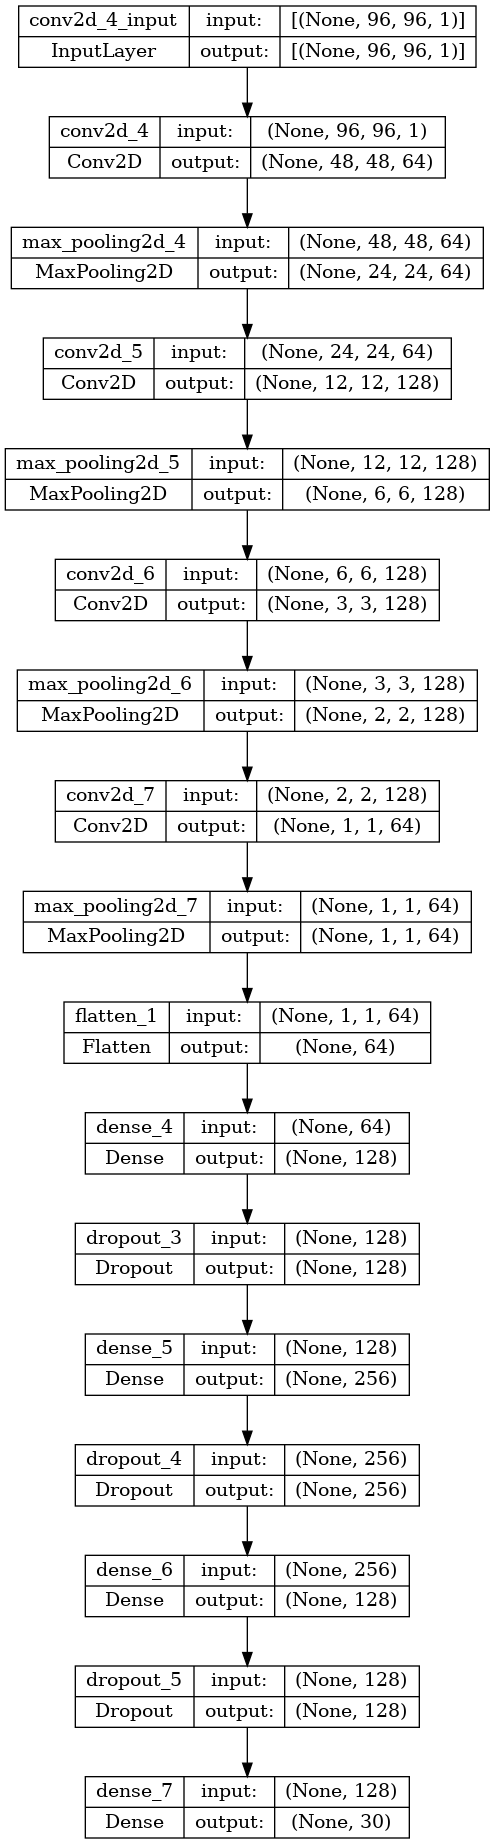

In [15]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

In [16]:
def test_model(model):    
    data_path = join('','*g')
    files = glob.glob(data_path)
    # Test on first 10 samples of the test set
    for i in range(len(imgs_test)):
        test_img_input = np.reshape(imgs_test[i], (1,96,96,1))      # Model takes input of shape = [batch_size, height, width, no. of channels]
        prediction = model.predict(test_img_input)      # shape = [batch_size, values]
        visualize_points(imgs_test[i], prediction[0])
        if i == 10:
            break

1/1 [==============================] - 0s 26ms/step


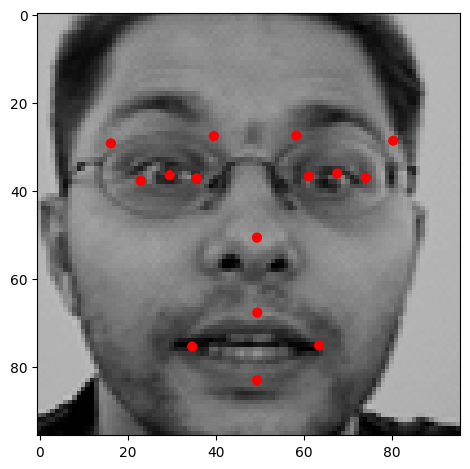

1/1 [==============================] - 0s 26ms/step


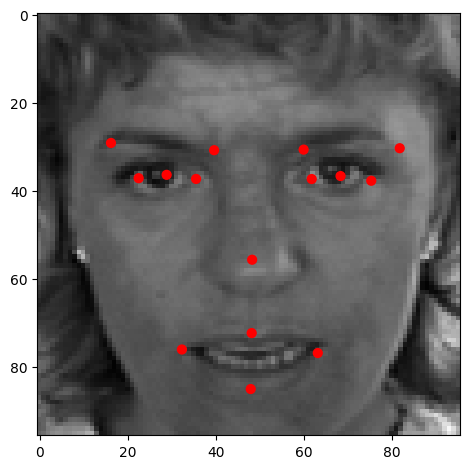

1/1 [==============================] - 0s 23ms/step


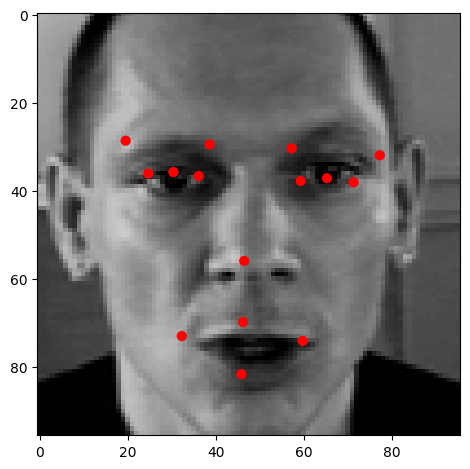

1/1 [==============================] - 0s 34ms/step


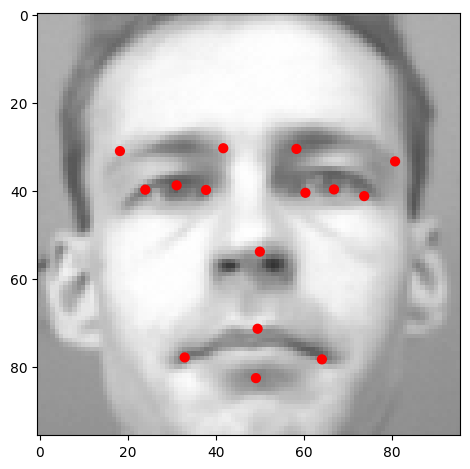

1/1 [==============================] - 0s 24ms/step


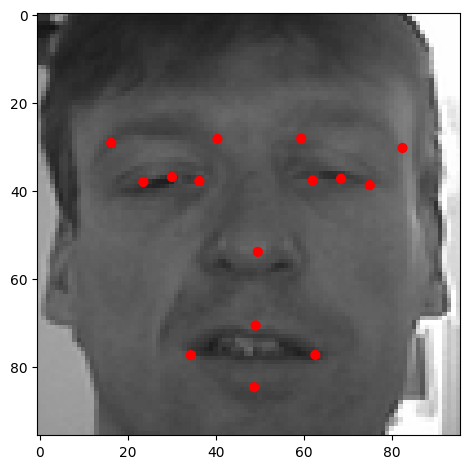

1/1 [==============================] - 0s 26ms/step


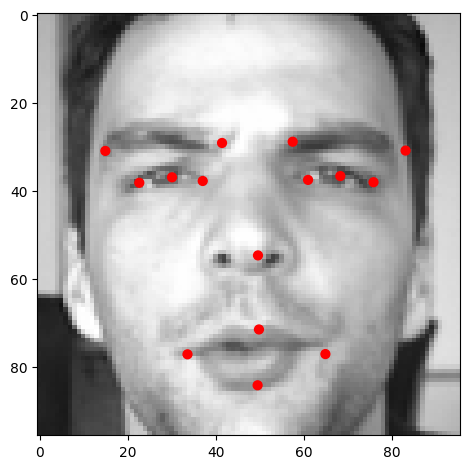

1/1 [==============================] - 0s 27ms/step


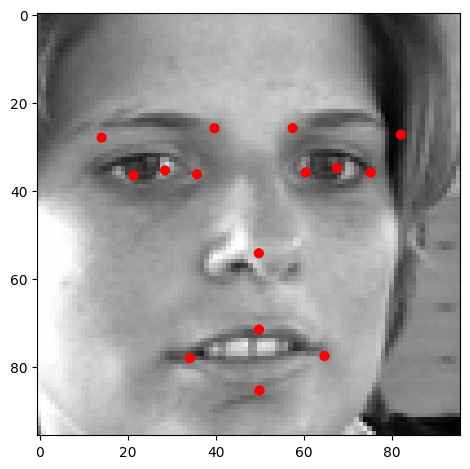

1/1 [==============================] - 0s 33ms/step


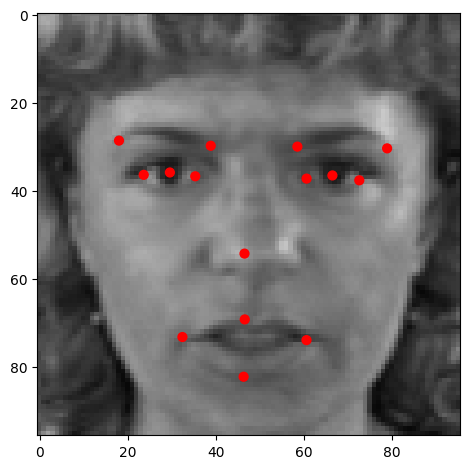

1/1 [==============================] - 0s 29ms/step


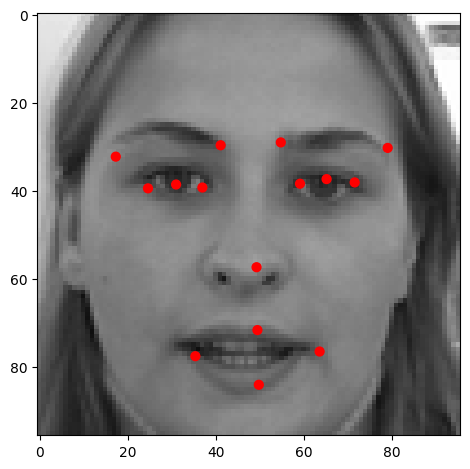

1/1 [==============================] - 0s 25ms/step


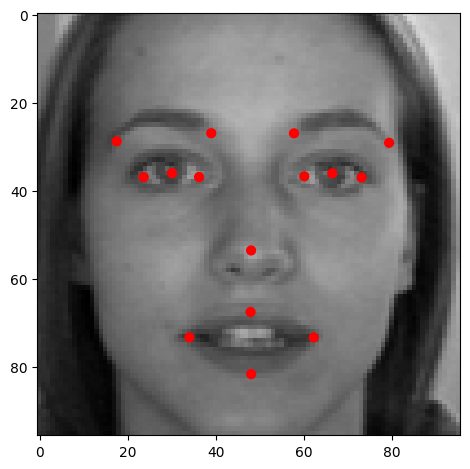

1/1 [==============================] - 0s 27ms/step


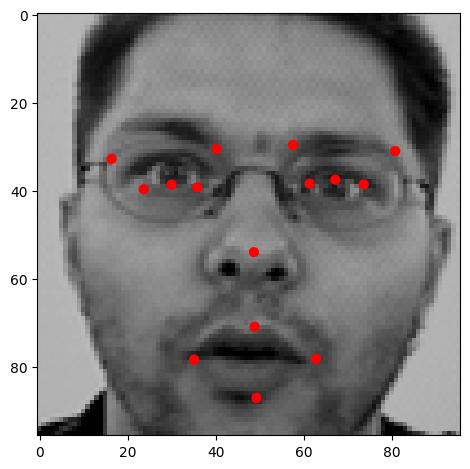

In [17]:
test_model(model)

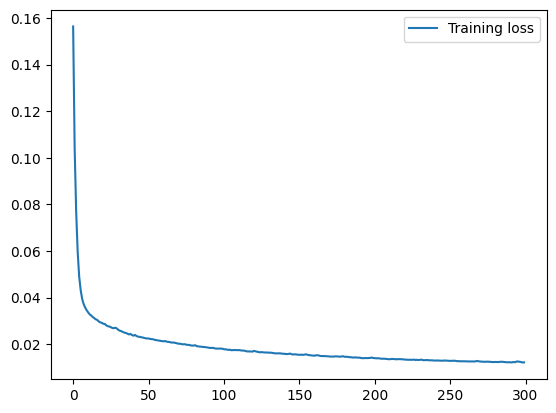

In [21]:
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.legend()
plt.show()